In [3]:
from datasets import load_dataset
import pandas as pd 
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import warnings

from collections import Counter, defaultdict
from datasets import load_dataset
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam

from spacy.matcher import Matcher
import spacy
import nltk
import re
import plotly.express as px
from transformers import AutoTokenizer, TFAutoModel

from wordcloud import WordCloud

# Additional setup
warnings.filterwarnings('ignore')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nlp = spacy.load("en_core_web_sm")



import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'datasets'

In [46]:

class Metrics:
    def __init__(self):
        self.results = {}

    def run(self, y_true, y_pred, method_name, average='macro'):
        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average=average)
        recall = recall_score(y_true, y_pred, average=average)
        f1 = f1_score(y_true, y_pred, average=average)

        # Store results
        self.results[method_name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
        }

    def plot(self):
        # Create subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 10))

        # Plot each metric
        for i, metric in enumerate(['accuracy', 'precision', 'recall', 'f1']):
            ax = axs[i//2, i%2]
            values = [res[metric] * 100 for res in self.results.values()]
            ax.bar(self.results.keys(), values)
            ax.set_title(metric)
            ax.set_ylim(0, 100)

            # Add values on the bars
            for j, v in enumerate(values):
                ax.text(j, v + 0.02, f"{v:.2f}", ha='center', va='bottom')

        plt.tight_layout()
        plt.show()

### Breakdown SuperGlue + All Datasets / What each dataset is used for. 

In [49]:
dataset = load_dataset("super_glue", 'boolq')


Generating train split:   0%|          | 0/9427 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3270 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3245 [00:00<?, ? examples/s]

In [50]:
dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 9427
    })
    validation: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3270
    })
    test: Dataset({
        features: ['question', 'passage', 'idx', 'label'],
        num_rows: 3245
    })
})

In [51]:
# turn dataset into pandas dataframe
train = pd.DataFrame(dataset['train'])
val = pd.DataFrame(dataset['validation'])
test = pd.DataFrame(dataset['test'])



In [52]:
train.head()

,question,passage,idx,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,1
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,1
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,1
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,1
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,0


## Note the validation set is used for training and validation. The test set does not have valid labels, because it is used to submit to the leaderboard.

In [54]:
# merge premise and hypothesis into one column
train['all_text'] = train['question'] + ' ' + train['passage'] 
test['all_text'] = test['question'] + ' ' + test['passage']
val['all_text'] = val['question'] + ' ' + val['passage']

In [64]:
# create a pipeline with tfidf minimal preprocessing and a binary classifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

pipe = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', LogisticRegression())
])
# define param grid
param_grid = {
    'tfidf__max_df': [0.75, 1.0],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'tfidf__stop_words': ['english'],
    'clf__C': [0.1, 1.0, 10.0],
    'clf__solver': ['liblinear']
}

from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(train.all_text, train.label)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1.0, 10.0],
                         'clf__solver': ['liblinear'],
                         'tfidf__max_df': [0.75, 1.0],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__stop_words': ['english']})

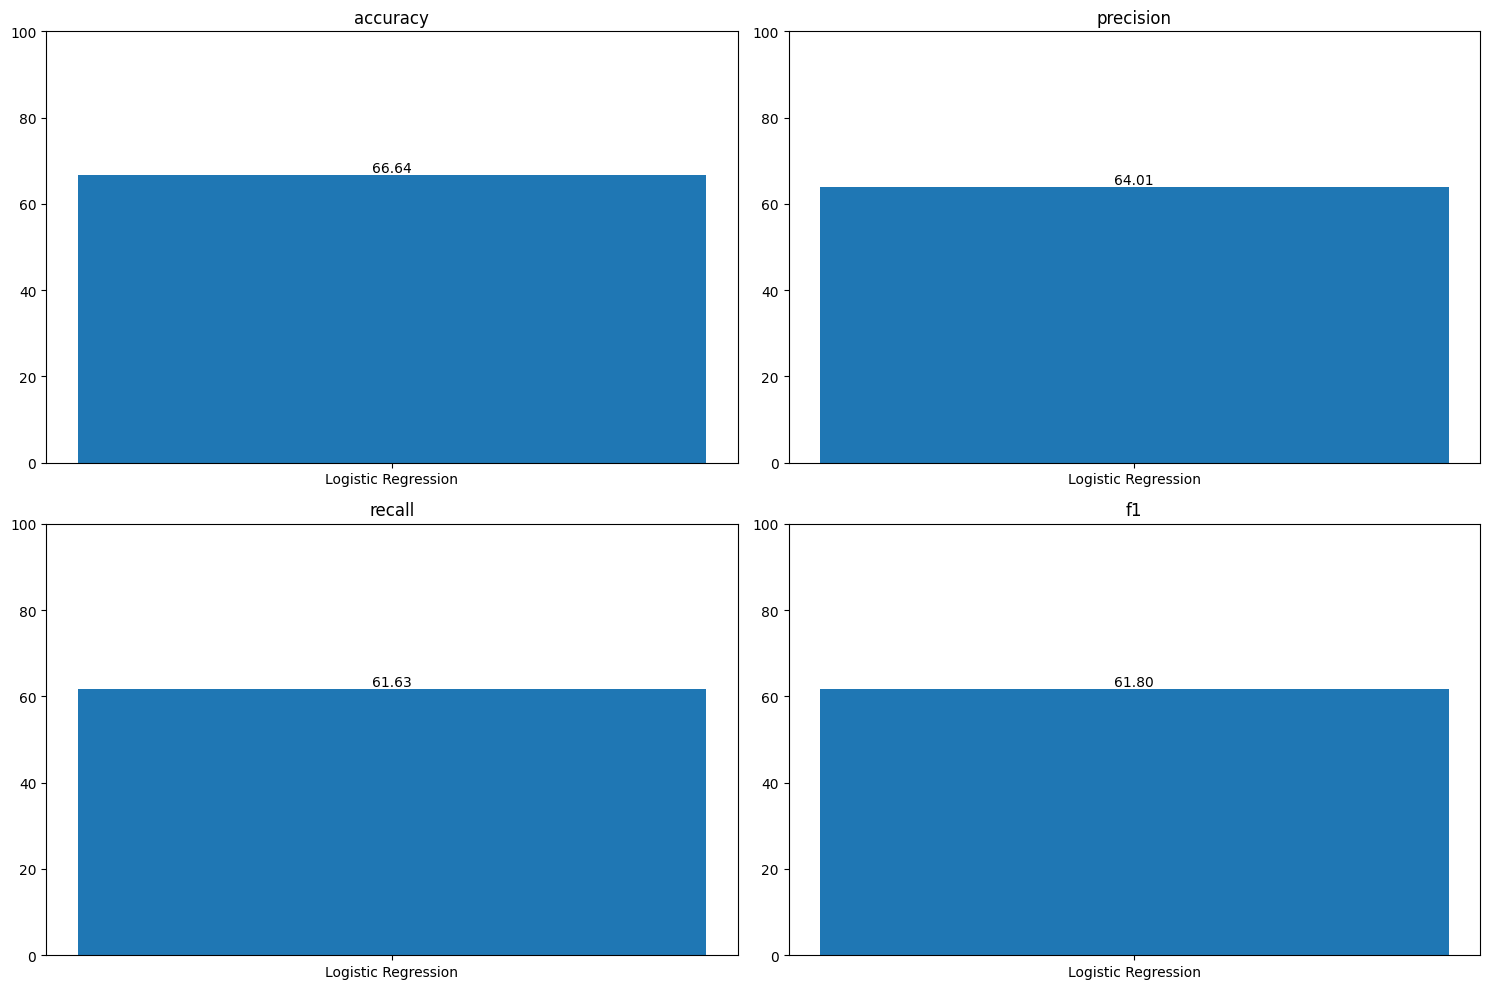

In [75]:
# predict on test set and get accuracy metrics for the model
valid_pred_tfidf = grid.predict(val.all_text)

metrics = Metrics()
metrics.run(val.labels, valid_pred_tfidf, 'Logistic Regression')
metrics.plot()

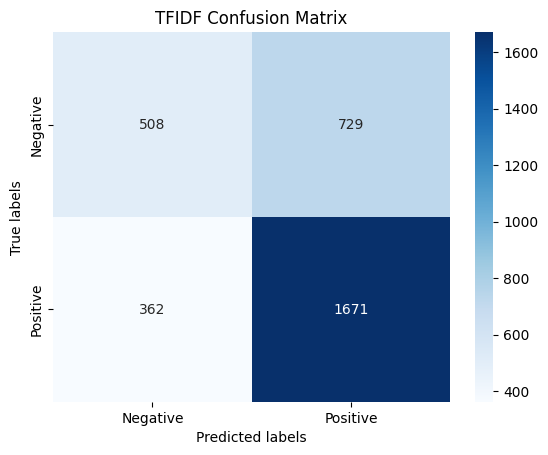

In [79]:


cm = confusion_matrix(val.labels, valid_pred_tfidf)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('TFIDF Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative', 'Positive'])
ax.yaxis.set_ticklabels(['Negative', 'Positive'])
plt.show()



In [81]:
# append predictions to the validation set and print false positives 
val['pred'] = valid_pred_tfidf

false_positives = val[(val['pred'] != val['label']) & (val['pred'] == 1)]
false_negatives = val[(val['pred'] != val['label']) & (val['pred'] == 0)]

# subset 

# write false positives to a txt file 
with open('false_positives.txt', 'w') as f:
    for text in false_positives['all_text']:
        f.write(text + '\n\n')

# write false negatives to a txt file
with open('false_negatives.txt', 'w') as f:
    for text in false_negatives['all_text']:
        f.write(text + '\n\n')
        

### False Positive Analysis - The answer to the question is no, but the model predicted yes. 

Human Inference

There are some responses to the question where the answer is buried in the text, also, there are clear relationships between the question and the answer that may be highly correlated. 

1. is barq's root beer a pepsi product Barq's -- Barq's /ˈbɑːrks/ is an American soft drink. Its brand of root beer is notable for having caffeine. Barq's, created by Edward Barq and bottled since the turn of the 20th century, is owned by the Barq family but bottled by the Coca-Cola Company. It was known as Barq's Famous Olde Tyme Root Beer until 2012.
    * barq's may be highly correlated to 1 here 
2. did boo the world's cutest dog die Boo (dog) -- In April 2012, Boo was the subject of a death hoax after #RIPBOO appeared on Facebook. Tweets followed as Gizmodo writer Sam Biddle tweeted that Boo had died. It was later confirmed by the Chronicle Book staff that Boo was alive and well.
    * death may be highly correlated to 1 here
3. Is antarctica the same as the south pole South Pole -- Situated on the continent of Antarctica, it is the site of the United States Amundsen--Scott South Pole Station, which was established in 1956 and has been permanently staffed since that year. The Geographic South Pole is distinct from the South Magnetic Pole, the position of which is defined based on the Earth's magnetic field. The South Pole is at the center of the Southern Hemisphere.
    * South Pole may be highly correlated to 1 here

To analyze these further, we train a Randome Forest model on the train set, predict proba on sentence 1, then look at the most important features for class label 0 and 1. 


In [95]:
# create tfidf vectorizer 
tfidf = TfidfVectorizer(max_df=0.75, ngram_range=(1, 2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(train.all_text)

# fit log reg model
clf = LogisticRegression(C=1.0, solver='liblinear')
clf.fit(X_train_tfidf, train.label)


sentence = "is barq's root beer a pepsi product Barq's -- Barq's /ˈbɑːrks/ is an American soft drink. Its brand of root beer is notable for having caffeine. Barq's, created by Edward Barq and bottled since the turn of the 20th century, is owned by the Barq family but bottled by the Coca-Cola Company. It was known as Barq's Famous Olde Tyme Root Beer until 2012."
# put each word through the pipeline and get the prediction
# split sentence into words
words = sentence.split()
true_predictions = []
false_predictions = []

for word in words:
    val = tfidf.transform([word])
    predictions = clf.predict_proba(val)
    true_predictions.append(predictions[0][1])
    false_predictions.append(predictions[0][0])

print(true_predictions)



[0.6278400171354508, 0.6813346648997001, 0.5659442823216742, 0.587599951660984, 0.6278400171354508, 0.5649124685415466, 0.5765987112641311, 0.6813346648997001, 0.6278400171354508, 0.6813346648997001, 0.6357144967112338, 0.6278400171354508, 0.6278400171354508, 0.8132563852158299, 0.6722419927318101, 0.6314957214042155, 0.6278400171354508, 0.6879799072999734, 0.6278400171354508, 0.5659442823216742, 0.587599951660984, 0.6278400171354508, 0.5799092254167758, 0.6278400171354508, 0.6548837856625915, 0.5665616483235236, 0.6813346648997001, 0.5528415205096036, 0.6278400171354508, 0.7239072333249508, 0.6813346648997001, 0.6278400171354508, 0.6482279089781765, 0.6278400171354508, 0.6278400171354508, 0.6499535079779986, 0.6278400171354508, 0.6278400171354508, 0.5590599577035339, 0.5505254262170479, 0.6278400171354508, 0.5642270453280492, 0.6278400171354508, 0.6278400171354508, 0.6813346648997001, 0.6219286187271351, 0.6278400171354508, 0.6482279089781765, 0.6278400171354508, 0.6278400171354508, 0

In [96]:
# plot the flase predictions 
fig = px.bar(x=words, y=false_predictions, labels={'x': 'Word', 'y': 'False Prediction Probability'})
fig.show()

In [97]:
# plot the flase predictions 
fig = px.bar(x=words, y=true_predictions, labels={'x': 'Word', 'y': 'False Prediction Probability'})
fig.show()

Keyword Analysis + Topic Relevance

We noticed that there is a topic statement after the question that the response should be relevant to. This may help us identify false positives where the response is targeted more generally at an irrelevant topic in the question, and not getting the main point of the question. For example, in statement 1, the topic statement is "Toyota Highlander." 

The response has missed the point of the question relevant to the keyword. For example, in statement 1 below, the question is mainly pointing at the truck frame, but the response does not mention the truck frame. Similarly, in statement 2, the question is about a sequel, but the response doesnt mention a sequel . In statement 3, the question is about a "true story," but the response does not mention the origins of the book the Outcast.

1. is the toyota highlander on a truck frame Toyota Highlander -- Announced in April 2000 at the New York Auto Show and arriving in late 2000 in Japan and January 2001 in North America, the Highlander became one of the first car-based mid-size SUV or mid-size crossovers. The Highlander is the crossover counterpart to the more rugged, truck-based midsize 4Runner and became Toyota's best-selling SUV before being surpassed by the smaller RAV4 in 2006. In Japan, the Kluger is exclusive to dealership network called Toyota NETZ as a larger alternative to the RAV4.

2. is there a sequel to love finds a home Love Finds a Home -- Love Finds a Home is a Christian drama film, the eighth and final installment based on a series of books by Janette Oke. It aired on Hallmark Channel on September 5, 2009. The film is based on the book Love Finds a Home by Janette Oke. Sarah Jones, Haylie Duff, and Jordan Bridges reprise their roles from Love Takes Wing.

3. is the outcasts based on a true story The Outcasts (2017 film) -- The Outcasts is a 2017 American teen comedy film directed by Peter Hutchings. The film features an ensemble cast, featuring Eden Sher, Victoria Justice, Ashley Rickards, Claudia Lee and Katie Chang. The plot follows a group of misfit teenagers who band together to overthrow the popular clique at their high school. Originally titled The Outskirts, filming took place between July and August 2014.

We could possibly address human inference with more ample resources and training, with segmentation masks and more data. However, it is easier for our purposes to address keyword analysis and topic relevance with simpler part of speech methodologies. 

Question Analysis 

### BERT Model Limited Data 

In [104]:

checkpoint="distilbert-base-uncased"# let's go faster !
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = TFAutoModel.from_pretrained(checkpoint)

batch_size=64
max_length=64
rate = 0.5 # dropout parameters
num_labels = len(np.unique(valid.label))

AttributeError: 'NoneType' object has no attribute 'items'

In [ ]:

## Input
input_ids_in = tf.keras.layers.Input(shape=(max_length,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_length,), name='masked_token', dtype='int32')

# Embedding layers
embedding_layer = model(input_ids=input_ids_in, attention_mask=input_masks_in)
# we need only the first token representation nothing else from the last layer!
final_embedding_layer = embedding_layer[0]#last layer of BERT
# Extract only the [CLS] token's embeddings
cls_token_embeddings = final_embedding_layer[:, 0, :]

# Let's add some dropout to reduce overfitting
output_layer = tf.keras.layers.Dropout(rate, name='do_layer')(cls_token_embeddings)

# One dense layer to process the last layer
output = tf.keras.layers.Dense(num_labels,
                               kernel_initializer="glorot_uniform",
                               activation='softmax')(output_layer)


bert_model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = output)

bert_model.summary()

In [ ]:

def get_batches(X_train, y_train, tokenizer, batch_size, max_length):
    """
    Objective: Create a generator that yields batches of tokenized text and corresponding labels.
               The data is shuffled and looped through indefinitely.

    Inputs:
        - X_train (np.array): Array of text data (features).
        - y_train (np.array): Array of labels.
        - tokenizer (DistilBertTokenizer): Tokenizer for text data.
        - batch_size (int): Size of each batch.
        - max_length (int): Maximum length of tokenized sequences.
    Outputs:
        - Generator yielding batches of (inputs, targets).
    """

    # Pre-tokenize the entire dataset
    inputs = tokenizer.batch_encode_plus(list(X_train), add_special_tokens=True, max_length=max_length,
                                         padding='max', return_attention_mask=True,
                                         return_token_type_ids=True, truncation=True,
                                         return_tensors="np")

    input_ids = np.asarray(inputs['input_ids'], dtype='int32')
    attention_masks = np.asarray(inputs['attention_mask'], dtype='int32')

    # Shuffle and yield batches
    while True:
        X_train, y_train, input_ids, attention_masks = shuffle(X_train, y_train, input_ids, attention_masks, random_state=11)

        for i in range(0, len(X_train), batch_size):
            yield [input_ids[i:i + batch_size], attention_masks[i:i + batch_size]], y_train[i:i + batch_size]

In [ ]:

enc = OneHotEncoder(handle_unknown='ignore')
y_train = enc.fit_transform(np.array(train_labels).reshape(-1, 1)).toarray()

In [ ]:


X_train = np.array(train_data)

steps_per_epoch = int(len(X_train) / batch_size)

batches = get_batches(X_train, y_train, tokenizer, batch_size, max_length)

bert_model.compile(optimizer=Adam(2e-5),
                   metrics=[tf.keras.metrics.Recall(),
                   tf.keras.metrics.Precision()],
                   loss=tf.keras.losses.CategoricalCrossentropy())


In [ ]:
bert_model.fit(batches, epochs=10, steps_per_epoch=steps_per_epoch)